# EU Tariffs

## Data

- Impex 2d: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0007
- Impex 4d
- Impex 8d: https://www-genesis.destatis.de/datenbank/online/statistic/51000/table/51000-0015

## Notes

- Combined Nomenclature: https://taxation-customs.ec.europa.eu/customs-4/calculation-customs-duties/customs-tariff/combined-nomenclature_de
- a.n.g. = anderweitig nicht genannt


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import squarify
import sys
import json
from io import StringIO
from dotenv import dotenv_values
secrets = dotenv_values(".env") 

sys.path.append('..')
from utils.get_destatis_variable_values import get_destatis_variable_values
from utils.get_destatis_table import get_destatis_table
from utils.try_cache import try_cache

In [2]:
# Own research
food_codes_2d = [
    "WA01",
    "WA02",
    "WA03",
    "WA04",
    "WA05",
    "WA07",
    "WA08",
    "WA09",
    "WA10",
    "WA11",
    "WA15",
    "WA16",
    "WA17",
    "WA18",
    "WA19",
    "WA20",
    "WA21",
    "WA22",
]

raw = {}
data = {}

In [3]:
raw["impex2d"] = pd.read_csv("./data/51000-0007_de_flat.csv",
                               	delimiter=";",
                               	decimal=",",
                               	thousands=".",
                               	parse_dates=["time"],
                               	converters={ "value": lambda x: pd.to_numeric(x, errors="coerce")})

raw["impex8d"] =  pd.read_csv("./data/51000-0013_de_flat.csv",
								delimiter=";",
								decimal=",",
								thousands=".",
								parse_dates=["time"],
								converters={"value": lambda x: pd.to_numeric(x, errors="coerce")})

In [4]:
raw["country_codes"] = try_cache("./data/genesis-countries.json", lambda: get_destatis_variable_values(var="STLAH", token=secrets["DESTATIS_TOKEN"]))
data["country_codes"] = pd.DataFrame(data=json.loads(raw["country_codes"])["List"])

raw["product_codes_4d"] = try_cache("./data/genesis-products-4d.json", lambda: get_destatis_variable_values(var="WAM4", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_4d"] = pd.DataFrame(data=json.loads(raw["product_codes_4d"])["List"])

raw["product_codes_6d"] = try_cache("./data/genesis-products-6d.json", lambda: get_destatis_variable_values(var="WAM6", token=secrets["DESTATIS_TOKEN"]))
data["product_codes_6d"] = pd.DataFrame(data=json.loads(raw["product_codes_6d"])["List"])

Loaded cached data from ./data/genesis-countries.json
Loaded cached data from ./data/genesis-products-4d.json
Loaded cached data from ./data/genesis-products-6d.json


In [5]:
food_codes_4d = data["product_codes_4d"].loc[data["product_codes_4d"]["Code"].str[:4].isin(food_codes_2d)]["Code"]
food_codes_6d = data["product_codes_6d"].loc[data["product_codes_6d"]["Code"].str[:4].isin(food_codes_2d)]["Code"]
food_codes_6d.values

array(['WA010110', 'WA010121', 'WA010129', ..., 'WA229799', 'WA229899',
       'WA229999'], dtype=object)

In [11]:
def parse_genesis_csv(csv):
	return pd.read_csv(StringIO(csv),
            	header=5,
            	skiprows=[6],
            	skipfooter=3,
            	delimiter=";",
            	decimal=",",
            	thousands=".",
            	engine="python",
            	parse_dates=["Unnamed: 0"],
            	converters=destatis_converters
				).rename(columns={
    				"Unnamed: 0": "year",
    				"Unnamed: 1": "country",
    				"Unnamed: 2": "product_code",
    				"Unnamed: 3": "product_label",
				})
	
destatis_converters = {
	"Ausfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Ausfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Wert (US-Dollar)": lambda x: pd.to_numeric(x, errors="coerce"),
	"Einfuhr: Gewicht": lambda x: pd.to_numeric(x, errors="coerce")
}

def get_paged_destatis_table(codes: list[str], codes_per_request: int = 1, dry_run = False):
	chunks = [codes[i:i + codes_per_request] for i in range(0, len(codes), codes_per_request)]
	result = pd.DataFrame()
	print(f"Received {len(codes)} attribute codes, generated {len(chunks)} chunks")
	if (dry_run):
		return
	for i, chunk in enumerate(chunks):
		print(f"Loading {','.join(chunk)} ({i + 1}/{len(chunks)})")
		t = try_cache(f"./data/impex-6d/{'_'.join(chunk)}.csv",
			lambda: get_destatis_table(
				token=secrets["DESTATIS_TOKEN"],
				password=secrets["DESTATIS_PASSWORD"],
				tables=["51000-0009"],
				start_year=2024,
				attributes={"STLAH": "*", "WAM6": ",".join(chunk)},
				silent=False,
				skip_credential_validation=(i > 0))
		)
		d = parse_genesis_csv(t)
		result = pd.concat([result, d])

	return result

data["impex4d"] = get_paged_destatis_table(food_codes_6d.values, codes_per_request=5, dry_run=False)


Received 1020 attribute codes, generated 204 chunks
Loading WA010110,WA010121,WA010129,WA010130,WA010190 (1/204)
Loaded cached data from ./data/impex-6d/WA010110_WA010121_WA010129_WA010130_WA010190.csv
Loading WA010210,WA010221,WA010229,WA010231,WA010239 (2/204)
Loaded cached data from ./data/impex-6d/WA010210_WA010221_WA010229_WA010231_WA010239.csv
Loading WA010290,WA010310,WA010391,WA010392,WA010410 (3/204)
Loaded cached data from ./data/impex-6d/WA010290_WA010310_WA010391_WA010392_WA010410.csv
Loading WA010420,WA010511,WA010512,WA010513,WA010514 (4/204)
Loaded cached data from ./data/impex-6d/WA010420_WA010511_WA010512_WA010513_WA010514.csv
Loading WA010515,WA010519,WA010594,WA010599,WA010611 (5/204)
Loaded cached data from ./data/impex-6d/WA010515_WA010519_WA010594_WA010599_WA010611.csv
Loading WA010612,WA010613,WA010614,WA010619,WA010620 (6/204)
Loaded cached data from ./data/impex-6d/WA010612_WA010613_WA010614_WA010619_WA010620.csv
Loading WA010631,WA010632,WA010633,WA010639,WA01

In [26]:
data["impex2d"] =  raw["impex2d"][["statistics_code", "time","1_variable_attribute_label", "2_variable_attribute_label", "3_variable_attribute_code", "3_variable_attribute_label", "value", "value_unit", "value_variable_label", "value_q"]].rename(columns={
        "1_variable_attribute_label": "destination",
        "2_variable_attribute_label": "origin",
        "3_variable_attribute_code": "product_code",
        "3_variable_attribute_label": "product_label",
	})

data["impex8d"] =  raw["impex8d"][
    ["time", "value_variable_label", "value", "value_unit","1_variable_attribute_label", "2_variable_attribute_code","2_variable_attribute_label", "statistics_code","value_q"]
    ].rename(columns={
        "2_variable_attribute_code": "product_code",
        "2_variable_attribute_label": "product_label",
	})

In [23]:
d = data["impex4d"].loc[
    data["impex4d"]["country"] == "Vereinigte Staaten von Amerika"
	].nlargest(10, ["Einfuhr: Wert"])[["year", "country", "product_label", "Einfuhr: Wert", "Einfuhr: Gewicht"]]
d


,year,country,product_label,Einfuhr: Wert,Einfuhr: Gewicht
857,2024-01-01,Vereinigte Staaten von Amerika,"Pistazien in der Schale, frisch oder getrocknet",313278.0,48012.0
858,2024-01-01,Vereinigte Staaten von Amerika,"Mandeln, frisch oder getrocknet, ohne Schale",234028.0,54447.2
859,2024-01-01,Vereinigte Staaten von Amerika,Whisky,164607.0,25158.1
855,2024-01-01,Vereinigte Staaten von Amerika,"Filets vom Pazifischen Pollack, gefroren",132401.0,40480.1
857,2024-01-01,Vereinigte Staaten von Amerika,"Walnüsse ohne Schale, frisch oder getrocknet",131712.0,30701.3
855,2024-01-01,Vereinigte Staaten von Amerika,"Lebensmittelzubereitungen, a.n.g.",86963.0,4387.1
858,2024-01-01,Vereinigte Staaten von Amerika,"Pistazien ohne Schale, frisch oder getrocknet",75089.0,5943.5
858,2024-01-01,Vereinigte Staaten von Amerika,"Wein aus frischen Weintrauben, <=2l",35735.0,5709.9
855,2024-01-01,Vereinigte Staaten von Amerika,"Preiselbeeren und Moosbeeren, zubereitet",30061.0,8183.6
859,2024-01-01,Vereinigte Staaten von Amerika,"Weintrauben, frisch",27353.0,8922.3


## Welche Soja-Produkte werden aus den USA importiert?

In [20]:
soy_codes = [
    "WA12019000",
    "WA12081000",
    "WA15071090",
    "WA15079090",
    "WA21031000",
    "WA22029911",
    "WA22029915"
]

pd.set_option('display.max_colwidth', None)
d = data["impex8d"].loc[
    (data["impex8d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex8d"]["product_label"].str.contains("Soja"))
].sort_values("value", ascending=False)[["time", "product_label", "product_code", "value", "value_unit"]]

d

,time,product_label,product_code,value,value_unit
71189,2024-01-01,"Sojabohnen, auch geschrotet, a.n.g.",WA12019000,1630299.0,Tsd. EUR
26877,2024-01-01,Ölkuchen u.a. feste Rückstände von Sojaöl,WA23040000,1120665.0,Tsd. EUR
54501,2024-01-01,"Getränke aus Soja, Nüssen, Samen, a.n.g. l",WA22029915,190950.0,Tsd. EUR
71845,2024-01-01,"Rohes Sojaöl, zur Verwendung als Lebensmittel",WA15071090,56707.0,Tsd. EUR
106981,2024-01-01,"Sojasoße, zubereitet",WA21031000,50471.0,Tsd. EUR
53749,2024-01-01,"Sojaöl, raffiniert, zu Lebensmittelzwecken",WA15079090,48251.0,Tsd. EUR
19653,2024-01-01,"Rohes Sojaöl, zu industriellen Zwecken",WA15071010,38385.0,Tsd. EUR
53765,2024-01-01,"Getränke aus Soja, Eiweißgehalt >= 2,8 GHT l",WA22029911,36122.0,Tsd. EUR
18837,2024-01-01,Mehl von Sojabohnen,WA12081000,9238.0,Tsd. EUR
87621,2024-01-01,Sojabohnen zur Aussaat,WA12011000,5822.0,Tsd. EUR


## Welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert?

[Tamara Land](https://teams.microsoft.com/l/message/19:10965a64-ecbd-4f15-b439-11fb5e6d9016_12890091-0b84-46a7-abab-21ed93ef2430@unq.gbl.spaces/1744359699218?context=%7B%22contextType%22%3A%22chat%22%7D): 

> Also ich würde mal sagen, welche 10 Produkte aus dem Bereich Lebensmittel werden am meisten aus den USA importiert? Und ideal wäre es, wenn man das noch ins Verhältnis setzen könnte: Deutschland verarbeitet pro Jahr XX Tonnen Mandeln. XX Prozent davon werden aus dem Ausland importiert und der Anteil der USA an den Importen beträgt XX Prozent. Das wäre meine Wunschvorstellung.

In [27]:
d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(food_codes_2d))
].sort_values("value", ascending=False).reset_index()[:10]

d[["index", "time", "origin", "product_code", "product_label", "value", "value_unit"]]


,index,time,origin,product_code,product_label,value,value_unit
0,95759,2024-01-01,Vereinigte Staaten von Amerika,WA08,Genießbare Früchte und Nüsse,912342.0,Tsd. EUR
1,102065,2024-01-01,Vereinigte Staaten von Amerika,WA22,"Getränke, alkoholhaltige Flüssigkeiten, Essig",255691.0,Tsd. EUR
2,96485,2024-01-01,Vereinigte Staaten von Amerika,WA03,"Fische, Krebs- und Weichtiere",187111.0,Tsd. EUR
3,102215,2024-01-01,Vereinigte Staaten von Amerika,WA21,Verschiedene Lebensmittelzubereitungen,133619.0,Tsd. EUR
4,102365,2024-01-01,Vereinigte Staaten von Amerika,WA20,"Zubereitungen von Gemüse, Früchten usw.",61437.0,Tsd. EUR
5,95921,2024-01-01,Vereinigte Staaten von Amerika,WA07,"Gemüse, Pflanzen für Ernährung",42963.0,Tsd. EUR
6,96587,2024-01-01,Vereinigte Staaten von Amerika,WA02,Fleisch,31596.0,Tsd. EUR
7,96209,2024-01-01,Vereinigte Staaten von Amerika,WA05,Andere Waren tierischen Ursprungs,29138.0,Tsd. EUR
8,101411,2024-01-01,Vereinigte Staaten von Amerika,WA15,"Tierische und pflanzliche Fette, Öle, Wachs",27894.0,Tsd. EUR
9,100901,2024-01-01,Vereinigte Staaten von Amerika,WA18,Kakao und Zubereitungen aus Kakao,22296.0,Tsd. EUR


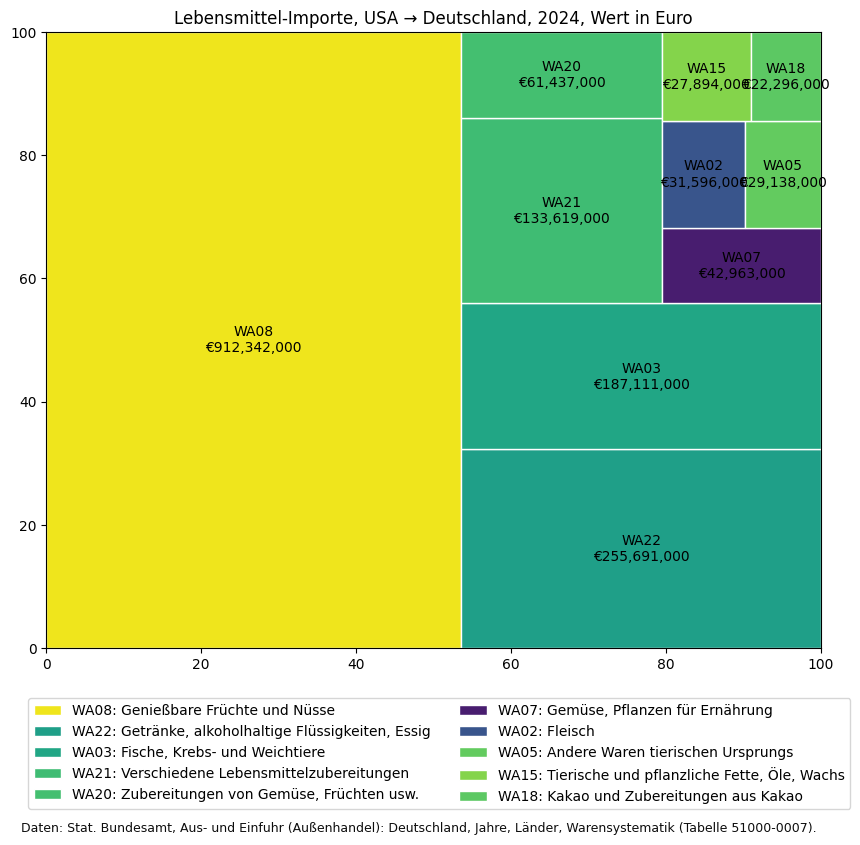

In [39]:
d = data["impex2d"].loc[
    (data["impex2d"]["value_variable_label"] == "Einfuhr: Wert")
    & (data["impex2d"]["origin"] == "Vereinigte Staaten von Amerika")
    & (data["impex2d"]["product_code"].isin(food_codes_2d))
].sort_values("value", ascending=False).reset_index()[:10]

fig, ax = plt.subplots(figsize=(10,8))
plt.title("Lebensmittel-Importe, USA → Deutschland, 2024, Wert in Euro")

d = d.sort_values("value", ascending=False)
short_label = d["product_code"] + "\n" + d["value"].apply(lambda x: f"€{round(x)*1000:,}")
long_label = d["product_code"] + ": " + d["product_label"]
# values = [10,50,130,140]
squarify.plot(d["value"], label=short_label, edgecolor="white")
fig.legend(long_label, loc="lower left", ncols=2, bbox_to_anchor=(.1, -.1, .8, 1))
ax.text(x=.1, y=-0.12, s="Daten: Stat. Bundesamt, Aus- und Einfuhr (Außenhandel): Deutschland, Jahre, Länder, Warensystematik (Tabelle 51000-0007).", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()